# Prelude

This section installs the necessary libraries for the notebook. Additionally, the notebook is connected to the data directory.

In [1]:
# Install the LMFIT library
!pip install lmfit

# Clone Allan Online repo to notebook directory
!git clone https://github.com/nurriol2/allan-online.git
import os
import sys
allan_online_dir = "./allan-online"
sys.path.append(os.path.abspath(allan_online_dir))

# Remaining imports
import fnmatch
import numpy as np
import pandas as pd
import scipy as scipy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import clear_output
from lmfit.models import ExpressionModel
from scipy.signal import find_peaks, peak_widths
clear_output()

In [2]:
# Access to the data directories
if os.path.isdir("/content/heterodyne/") and os.path.isdir("/content/split_detection/"):
    pass
else:
    !unzip /content/drive/MyDrive/allan_data/heterodyne.zip
    !unzip /content/drive/MyDrive/allan_data/split_detection.zip
clear_output()

# Helper functions

This section defines functions that help to set up longer workflows/pipelines.

In [3]:
def match_filenames_in_dir(pattern, directory):

    """
    Search a directory tree for all filenames which match a specified pattern.

    Args:
    pattern (str):  Expression for the filename template.

    directory (str):  Path to directory where data files are located.

    Returns:
    (list[str], list[str]):  A tuple of lists. 
                             The first list contains full paths to found files.
                             The second list contains only the file names.
    """

    # List of all found files that match pattern
    full_paths = []
    filenames = []
    # Walk the tree
    for root, dirs, files in os.walk(directory):
        for name in files:
            # Check that the filename matches the supplied pattern
            if fnmatch.fnmatch(name, pattern):
                full_paths.append(os.path.join(root, name))
                filenames.append(name)

    return (full_paths, filenames)


def center_zoom(arr, window):
    """
    Specify the size of a window to focus on the center of an array. 

    Args:
    arr (np.ndarray):  An array of values.

    window (int):  The size of the window to view.

    Returns:
    (np.ndarray):  The same as `arr` with window//2 elements to the left and 
                   right of the midpoint.
    """

    center = len(arr)//2
    left = center-window//2
    right = center+window//2
    selection = arr[left:right]

    return selection


# TODO:  Update to use new SplitbandData Class
def accumulate_splitband_areas(splitband_files):

    """
    Calculate the percent error between raw area and fit area in a list of
    SplitbandData files.

    Args:
    splitband_files (list[str]):  A list of SplitbandData filenames.
                                  Example:  "chb_st80_1.CSV" 

    Returns:
    (list[float]):  List of percent errors. 
    """
    
    calc_pct_err = lambda raw_area, fit_area : 100*(abs(fit_area-raw_area)/abs(raw_area))

    # Calculate percent error b/n raw and fit areas in all the files
    area_pct_err = []
    for filename in splitband_files:
        # Create a SplitbandData object from the filename
        splitband = SplitBandData(CHANNEL_A_DIRECTORY, filename, SPLITBAND_UNITS)
        # Fit a Lorentzian to the spectrum
        splitband.fit_1d_lorentzian()

        # Calculate the area under the spectrum data itself
        raw_area = splitband.raw_area
        # Calculate the area under the fit Lorentzian
        fit_area = splitband.fit_area
        # Calculate the percent error between the raw area and fit area
        area_pct_err.append(calc_pct_err(raw_area, fit_area))

    return area_pct_err 


def plot_percent_error(err_per_file, title="Percent Error between Raw Area and Fit Area"):

    """
    Encapsulate plotting a bar plot from the percent error data.

    Args:
    err_per_file (list[float]):  List of percent errors.

    title (str, optional):  Title of the resulting figure. 
                            Defaults to "Percent Error between Raw Area and Fit Area"
    """

    # Calculate the average percent error 
    avg_pct_err = np.mean(err_per_file)

    # Bar plot with horiz. line for average
    plt.figure(figsize=(10,8))
    plt.bar(np.arange(1, len(err_per_file)+1), err_per_file)
    plt.hlines(avg_pct_err, 1, len(err_per_file), color="red", label="Avg % Err")

    # Figure decorations
    plt.legend()
    plt.ylabel("% Error")
    plt.xlabel("File number")
    plt.title(f"{title}")
    plt.show()    
    return


def super_plot(frequencies, spectrum, fit_values, title, units="m^2/Hz"):

    # Calculate the residuals
    residuals = spectrum - fit_values


    # Set up a figure
    fig = plt.figure(figsize=(10, 8))
    # A grid over the figure to place subplots
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 0.25], hspace=0.25) # 2 rows x 1 column

    # Add subplots to the figure
    model_axes = fig.add_subplot(gs[0])
    resid_axes = fig.add_subplot(gs[1])

    # Add lines to the subplots
    ## Raw data and best fit curve
    model_axes.plot(frequencies, spectrum, label="Raw Data", color='k', marker='o')
    model_axes.plot(frequencies, fit_values, label="Best Fit", color='r', linestyle="dashed", linewidth=3)
    
    ## Residuals
    resid_axes.scatter(fit_values, residuals, color='b', marker='o')

    # Decorate subplots
    ## Raw data and best fit curve
    model_axes.set_title(f"{title}")
    model_axes.set_xlabel("Frequency (Hz)")
    model_axes.set_ylabel(f"{units}")
    model_axes.legend()

    ## Residuals
    resid_axes.set_xlabel("Fit Values")
    resid_axes.set_ylabel("Residual Value")
    resid_axes.set_title("Residuals Plot")

    plt.show(fig)
    plt.close(fig)
    return

# Classes

In [4]:
from dataclasses import dataclass, field

class Lorentzian:
    """
    A single peak Lorentzian.
    See https://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Lorentz1D.html

    Attrs:
    x (np.ndarray):  Points where the Lorentzian is evaluated.
    
    amp (float): The amplitude of the peak.

    cen (float):  The x-coodrinate of the Lorentzian peak.

    wid (float):  Half of the full width at half maximum (0.5*FWHM).

    back (float, optional): A cosntant representing the background offset.
                            Defaults to 0.0

    values (np.array): Values of the Lorentzian over x. Use these for plotting.
    """

    def __init__(self, x, amp, cen, wid, back):
        self.x = x
        self.amp = amp
        self.cen = cen
        self.wid = wid
        self.back = back
        self.values = self._single_peak_lorentzian()
        return 


    def _single_peak_lorentzian(self):
        """
        Calculate values of a single peak Lorentzian according to object attributes.

        Returns:
        (np.ndarray(float)):  Values for the Lorentzian computed over `x`
        """
        return (self.amp*self.wid**2/((self.x-self.cen)**2+self.wid**2))+self.back


    def area_under_curve(self):
        """
        Calculate the area under the Lorentzian.

        Returns:
        (float):  Area under the Lorentzian. 
        """
        return np.trapz(self.values)
    

    def mechanical_frequency(self):
        """
        Determine the amplitude of the peak.

        Returns:
        (flaot:  Amplitude of the peak.
        """
        return max(self.values)
    

    def linewidth(self):
        """
        Calculate the FWHM.

        Returns:
        (float):  The FWHM of the Lorentzian.
        """
        return 2*self.wid


    def all_values(self):
        """
        Create a dictionary of attributes, subscriptable by name.

        Returns:
        (dict):  Keys are fit_area, mechanical_frequency, and linewidth.
        """
        return {"fit_area":self.area_under_curve(),
                "mechanical_frequency":self.mechanical_frequency(),
                "linewidth":self.linewidth()}

# End Lorentzian


@dataclass
class SpectrumFile:
    """
    Class for working with sideband and heterodyne spectral density measurements
    """

    directory: str
    pattern: str
    units: str
    fullpath: str = field(init=False)
    frequencies: np.ndarray = field(init=False)
    spectrum: np.ndarray = field(init=False)

    def __post_init__(self):
        self.fullpath = os.path.join(self.directory, self.pattern)
        self.frequencies, self.spectrum = self.file_to_arrays()
        return 


    def _load_csv_file(self):
        """
        Load a single csv file into memory as a pandas.DataFrame
        
        Returns:
        (pd.DataFrame):  A pandas.DataFrame where the columns are Frequency (Hz)
                         and Spectral Density (...) with specified units.
        """

        return pd.read_csv(self.fullpath, names=["Frequency (Hz)", f"Spectral Density ({self.units})"])


    def _columns_to_array(self, df):
        """
        Create individual numpy arrays from columns of a data frame

        Args:
        df (pd.DataFrame):  The data frame to convert

        Returns:
        tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                        Length of tuple depends on number of columns.
        """
        result = []
        for _, col_data in df.iteritems():
            result.append(col_data.values)
        return result


    def file_to_arrays(self):

        """
        Process a single spectrum file into memeory as numpy arrays

        Returns:
        tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                        Length of tuple depends on number of columns.
        """

        df = self._load_csv_file()

        return self._columns_to_array(df)    


    def sort_key(self):
        """
        Find the file number from the path to a file.
        Example:  Extract the number 109 from /.../cha_st80_109.CSV

        Args:
        fullpath (str):  The full path to the CSV file

        Returns:
        (int):  The found file number
        """

        filename = self.fullpath.split('/')[-1]
        filenumber = filename.split('_')[-1].strip(".CSV")
        return filenumber   
        
    def trim_data(self, low=None, high=None):
        """
        Set the low and high frequency of the SpectrumFile object in place.
        Trim the spectrum array to the corresponding values.
        """
        
        # Call without parameters should return the original array
        low_index = 0
        high_index = len(self.frequencies)-1
        
        # Determine the index of the element closest to value
        # If multiple matches, takes the first occurance 
        close_elem_index = lambda array, value : np.absolute(array-value).argmin()
        
        if low is not None:
            low_index = close_elem_index(self.frequencies, low)
        if high is not None:
            high_index = close_elem_index(self.frequencies, high)
        
        self.frequencies = self.frequencies[low_index:high_index+1]
        self.spectrum = self.spectrum[low_index:high_index+1]
        return 
 

# End SpectrumFile



@dataclass
class SplitBandData(SpectrumFile):
    """
    Class for working with split band data.
    Example:  `cha_st80_1.CSV`
    """

    # Area under the spectrum
    raw_area: float = field(init=False)
    # Initial estimate for the width of the peak
    width_estimate: float = field(init=False)

    def __post_init__(self):
        super().__post_init__()
        self._set_width_estimate()
        self.raw_area = np.trapz(self.spectrum)
        return

    # TODO:  Associate width with the Lorentzian object?
    def _set_width_estimate(self):    
        estimate = peak_widths(self.spectrum, [np.argmax(self.spectrum)], rel_height=0.5)
        self.width_estimate = estimate[0].item(0)
        return

    def init_lorentzian(self):
        """
        Define a Lorentzian object from frequency and spectrum data
        """ 

        def _1Lorentzian(x, amp, cen, wid, back):
            return (amp*wid**2/((x-cen)**2+wid**2))+back
        
        # Frequency of peak
        center = self.frequencies[np.where(self.spectrum==self.spectrum.max())].item()
        
        optimal_params, _ = scipy.optimize.curve_fit(_1Lorentzian,
                                                    self.frequencies,
                                                    self.spectrum,
                                                    p0=[self.spectrum.max().item(),
                                                        center,
                                                        self.width_estimate,
                                                        self.spectrum.min().item()])

        return Lorentzian(self.frequencies, *optimal_params)

# End SplitBandData



@dataclass
class HeterodyneData(SpectrumFile):
    """
    Class for working with heterodyne data.
    Example:  `het_st80_1.CSV`

    NB: Scipy's optimize module has been shown to fit multiple peaks with less
        error than a composite model from LMFIT. For this use case, we only care
        about the measurements of the fit (e.g. FWHM, mechanical frequency, linewidth).
    """  

    # Area under the spectrum
    raw_area: float = field(init=False)
    # Initial estimates for the widths of each peak
    left_width:  float = field(init=False)
    right_width: float = field(init=False)
    main_width: float = field(init=False)
    

    def __post_init__(self):
        super().__post_init__()
        self._set_width_estimates()
        return


    def _set_width_estimates(self):
        estimates = peak_widths(self.spectrum, self._peak_selection(), rel_height=0.5)
        values = estimates[0]
        self.left_width = values[0]
        self.main_width = values[1]
        self.right_width = values[2]
        return 


    def _peak_selection(self):
        # Locate peaks in the spectrum by index
        peak_indices, _ = find_peaks(self.spectrum)
        # Select corresponding amplitudes of found peaks
        peak_amplitudes = self.spectrum[peak_indices]
        
        # Sort the peaks according to height; largest to smallest
        amp_idx_pairs = list(zip(peak_amplitudes, peak_indices)) 
        amp_idx_pairs.sort(key=lambda pair : pair[0], reverse=True)

        # Track the left and right side peaks
        left_idx = None
        right_idx = None

        # Main peak is always the tallest
        main_amp, main_idx = amp_idx_pairs[0]

        # The next tallest peak should appear on one side of the main peak
        side_a_amp, side_a_idx = amp_idx_pairs[1]

        # The opposite side peak depends on where side_a peak is located
        side_b_pair = None
        # The side_a peak was left of the main peak
        if side_a_idx < main_idx:
            left_idx = side_a_idx
            # Compare indices to find the tallest peak on the right of the main peak
            right_idx = (next(pair[1] for pair in amp_idx_pairs[2:] if pair[1] > main_idx))
        # The side_a peak was right of the main peak
        else:
            right_idx = side_a_idx
            # Compare indices to find the tallest peak on the left of the main peak
            left_idx = (next(pair[1] for pair in amp_idx_pairs[2:] if pair[1] < main_idx))

        return (left_idx, main_idx, right_idx)


    def fit_right_peak(self, tune=0.75):
        """
        Note:   This function will irreversibly mutate the HetrodyneData object.
                Create a new HeteroDyne object to fit main or left peaks.
        """

        _, main_loc, right_loc = self._peak_selection()
        # Find the frequency that escapes main peak influence
        escape_index = int(main_loc + tune*(right_loc-main_loc))
        # Trim the spectrum according to `escape_index`
        trim_low = self.frequencies[escape_index]
        self.trim_data(low=trim_low)
        
        # Right index has the property that it's distance from end of array is constant
        dyn_right_loc = -1*(len(self.frequencies)-right_loc)
        # Initial guess for Lorentzian
        right_guess = [self.spectrum[dyn_right_loc],
                       self.frequencies[dyn_right_loc],
                       self.right_width,
                       self.spectrum.min()]

        def _1Lorentzian(x, amp, cen, wid, back):
            return (amp*wid**2/((x-cen)**2+wid**2))+back

        # Fit Lorentzian parameters
        right_optimal_params, _ = scipy.optimize.curve_fit(_1Lorentzian,
                                                           self.frequencies,
                                                           self.spectrum,
                                                           p0=right_guess,
                                                           maxfev=5000)

        return Lorentzian(self.frequencies, *right_optimal_params)

    def fit_left_peak(self, tune=0.40):
        """
        Note:   This function will irreversibly mutate the HetrodyneData object.
                Create a new HeteroDyne object to fit main or right peaks.
        """

        left_loc, main_loc, _ = self._peak_selection()
        # Find the frequency that escapes main peak influence
        escape_index = int(main_loc - tune*(main_loc-left_loc))
        # Trim the spectrum according to `escape_index`
        trim_high = self.frequencies[escape_index]
        self.trim_data(high=trim_high)
        
        # Left index has the property that it's distance from start of array is constant
        # Initial guess for Lorentzian
        left_guess = [self.spectrum[left_loc],
                       self.frequencies[left_loc],
                       self.left_width,
                       self.spectrum.min()]

        def _1Lorentzian(x, amp, cen, wid, back):
            return (amp*wid**2/((x-cen)**2+wid**2))+back

        # Fit Lorentzian parameters
        left_optimal_params, _ = scipy.optimize.curve_fit(_1Lorentzian,
                                                           self.frequencies,
                                                           self.spectrum,
                                                           p0=left_guess,
                                                           maxfev=5000)

        return Lorentzian(self.frequencies, *left_optimal_params)
# End HeterodyneData

---

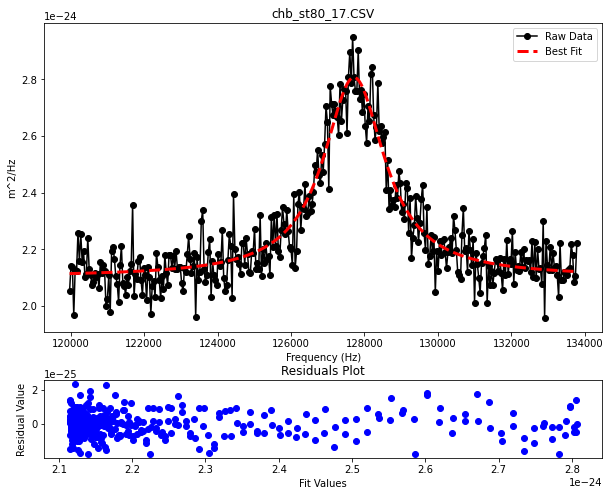

In [5]:
# Try super_plot
filename = "chb_st80_17.CSV"
split = SplitBandData("/content/split_detection", filename, "m^2/Hz")
split_lorentzian = split.init_lorentzian().values

super_plot(split.frequencies, split.spectrum, split_lorentzian, f"{filename}")

In [6]:
#rnum = np.random.randint(1,125)
rnum = 21 # Trouble finding big peaks
#rnum = 114 # Trouble finding small peaks
heterodyne = HeterodyneData("/content/heterodyne/", f"het_st80_{rnum}.CSV", "V^2/Hz")

Text(0.5, 1.0, 'Heterodyne 21 Raw Data')

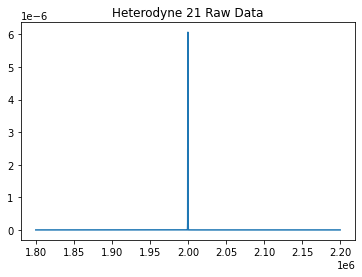

In [7]:
plt.plot(heterodyne.frequencies, heterodyne.spectrum)
plt.title(f"Heterodyne {rnum} Raw Data")

In [8]:
right_lorentzian = heterodyne.fit_right_peak()

Text(0.5, 1.0, 'Heterodyne 21 Trimmed')

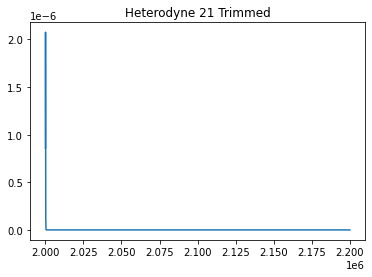

In [9]:
plt.plot(heterodyne.frequencies, heterodyne.spectrum)
plt.title(f"Heterodyne {rnum} Trimmed")

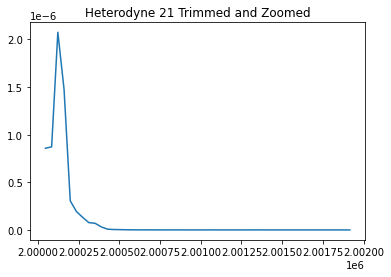

In [10]:
plt.plot(heterodyne.frequencies[:50], heterodyne.spectrum[:50])
plt.title(f"Heterodyne {rnum} Trimmed and Zoomed")
plt.show()

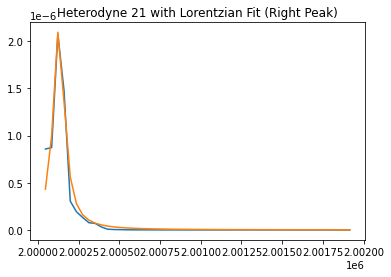

In [11]:
plt.plot(heterodyne.frequencies[:50], heterodyne.spectrum[:50])
plt.plot(heterodyne.frequencies[:50], right_lorentzian.values[:50])
plt.title(f"Heterodyne {rnum} with Lorentzian Fit (Right Peak)")
plt.show()

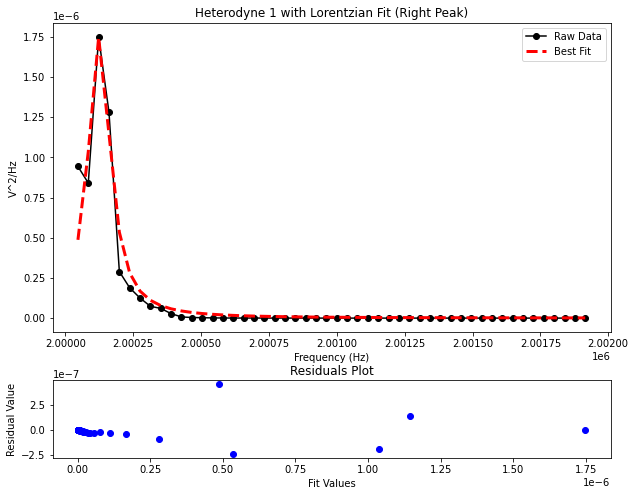

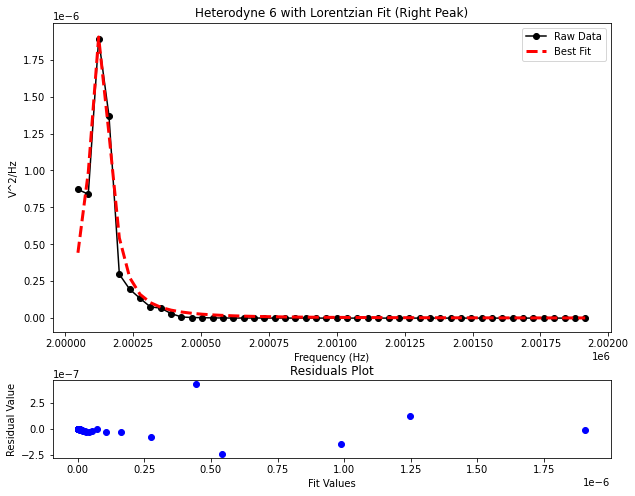

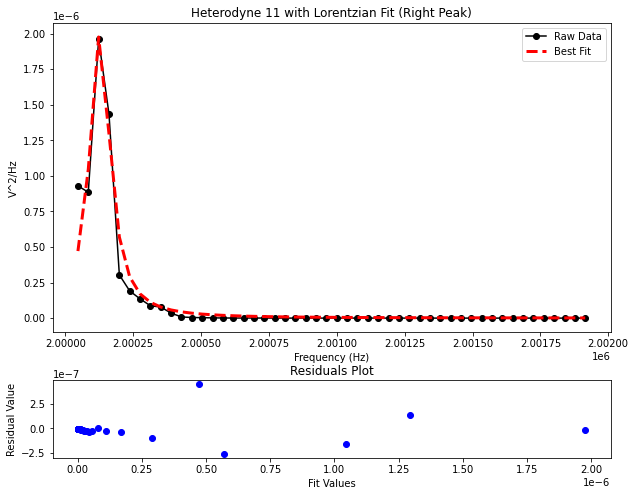

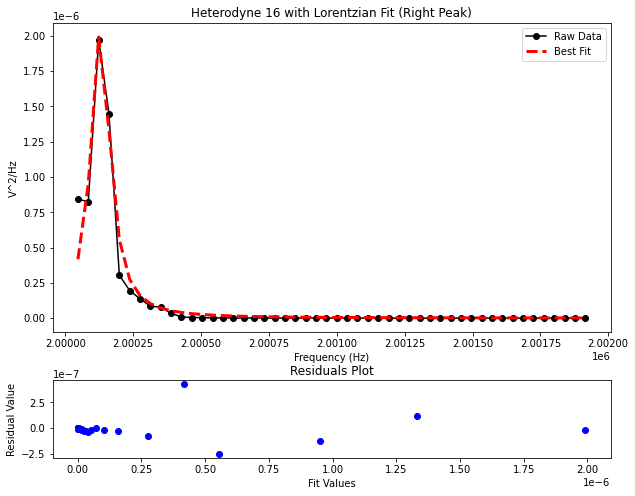

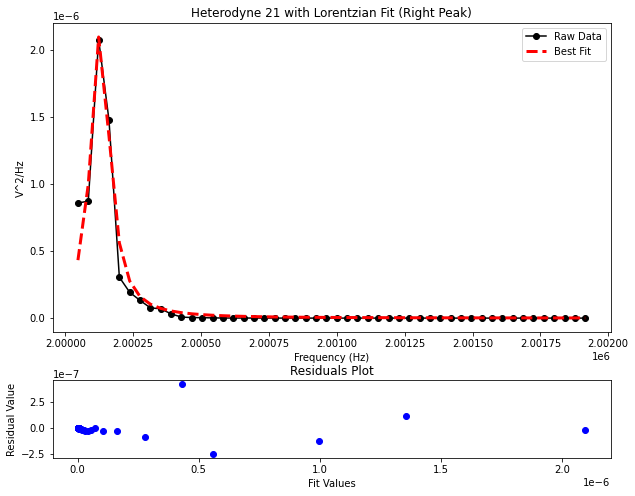

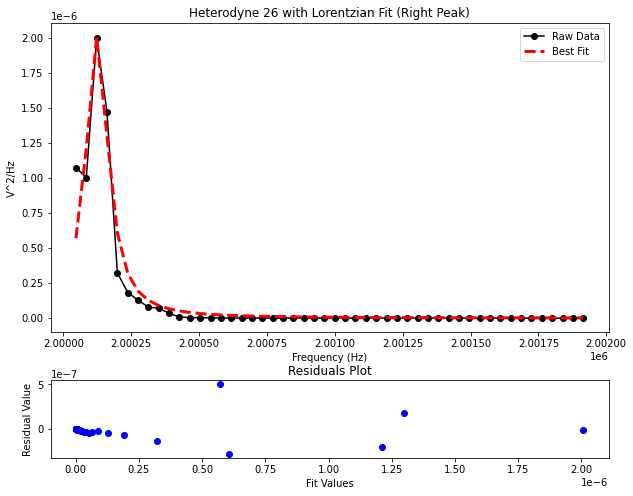

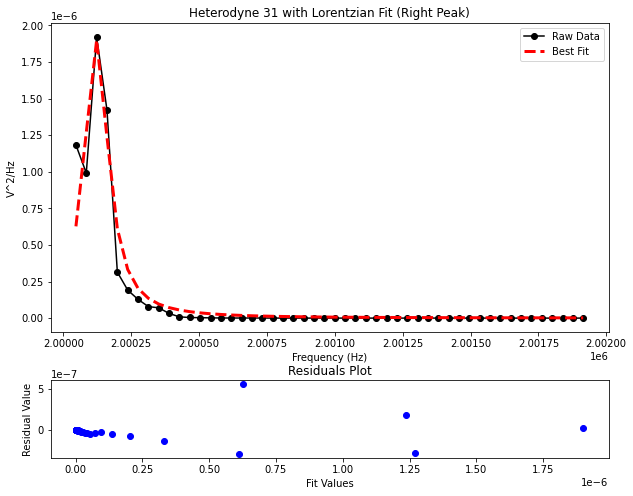

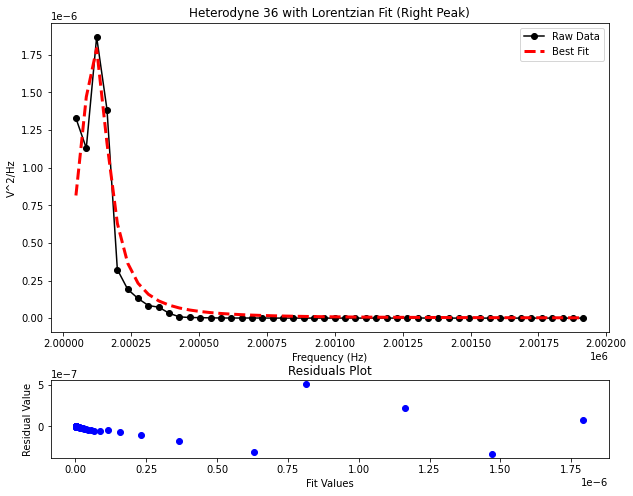

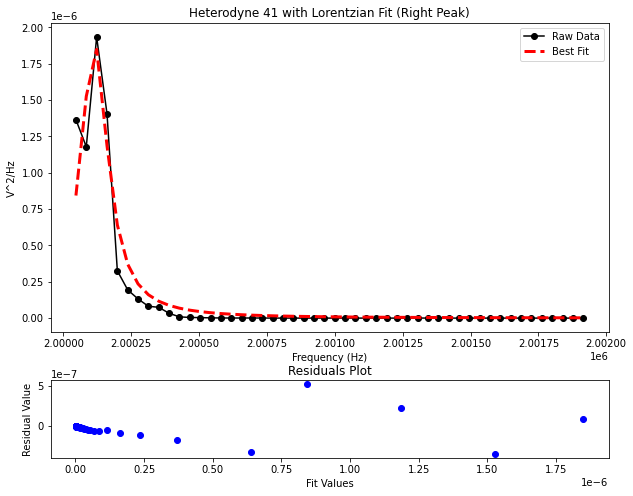

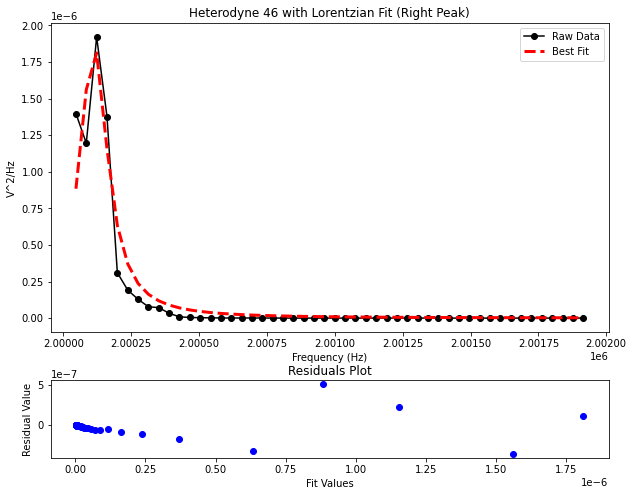

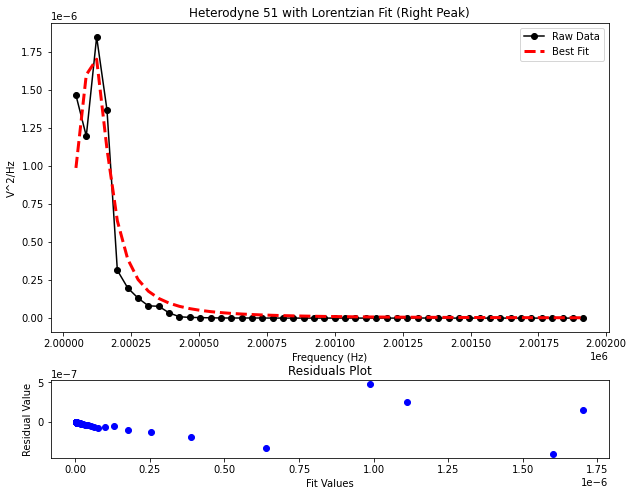

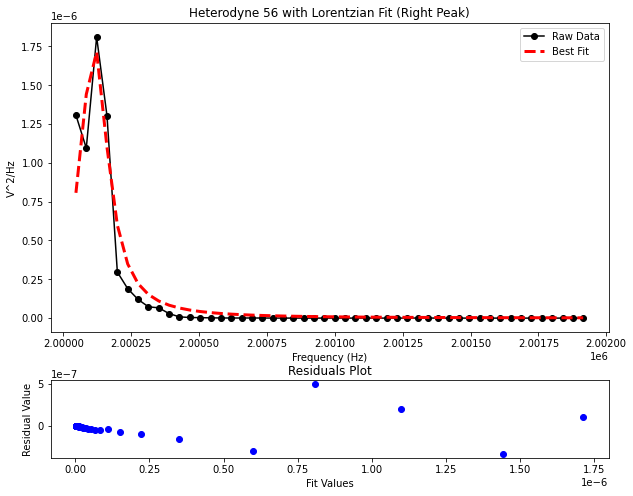

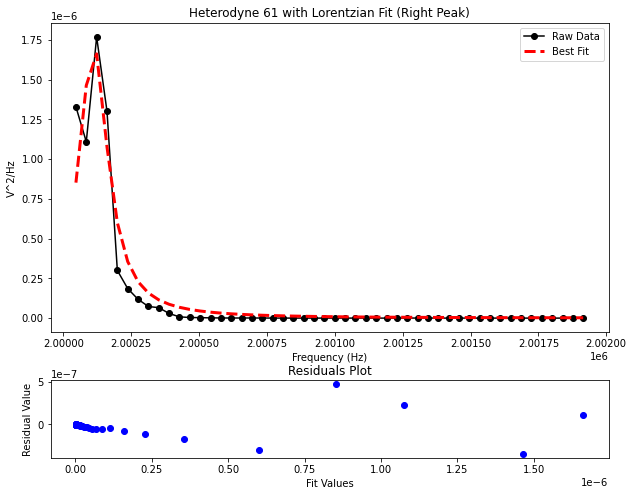

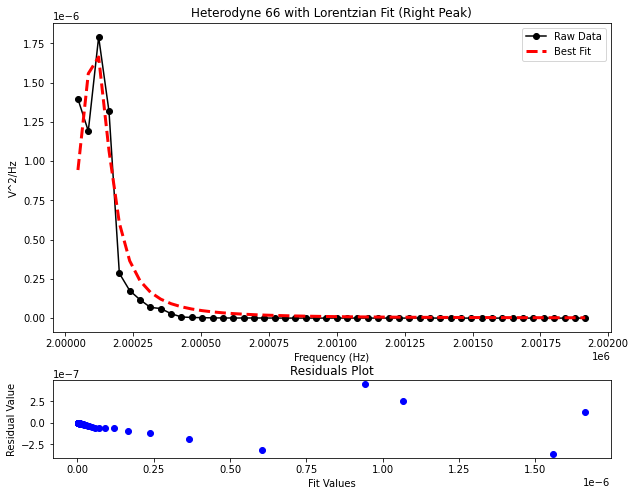

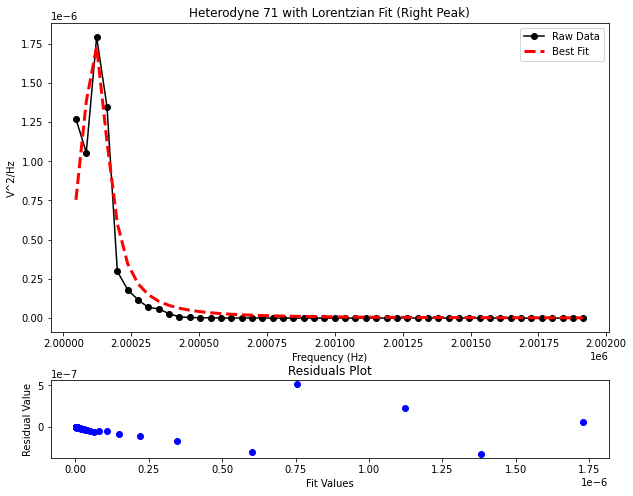

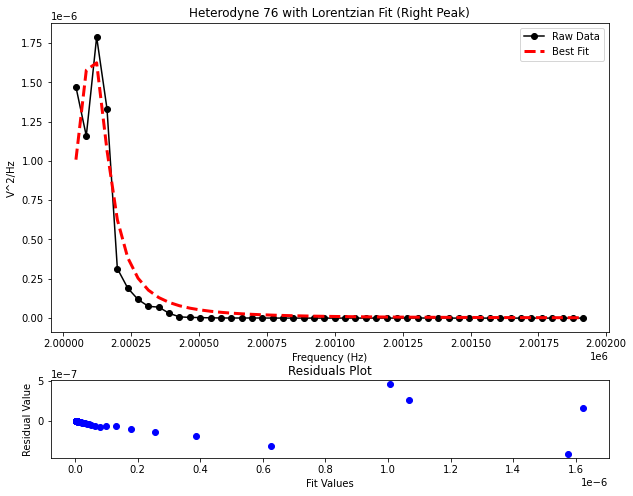

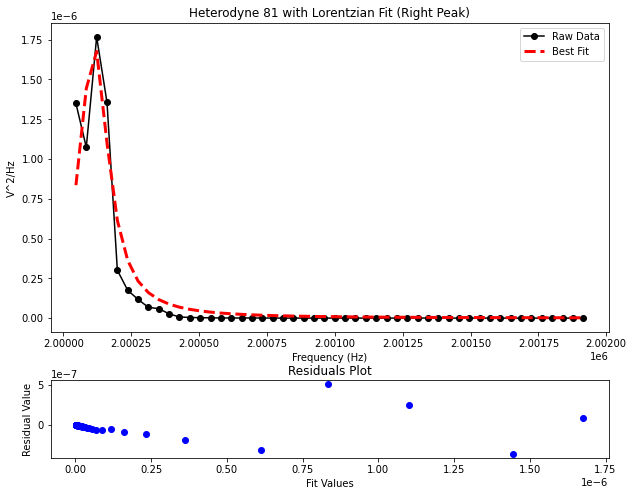

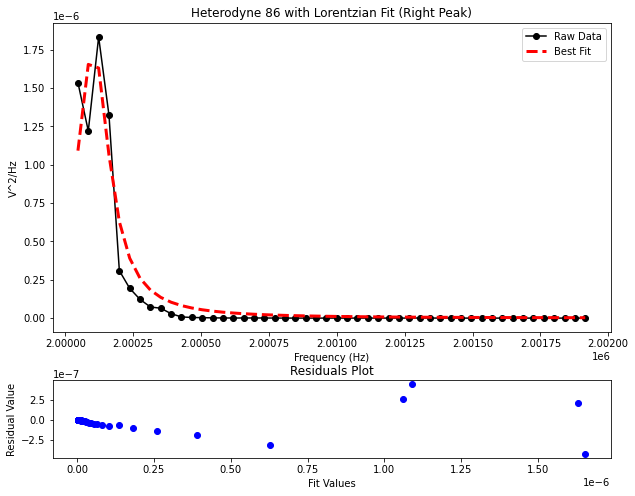

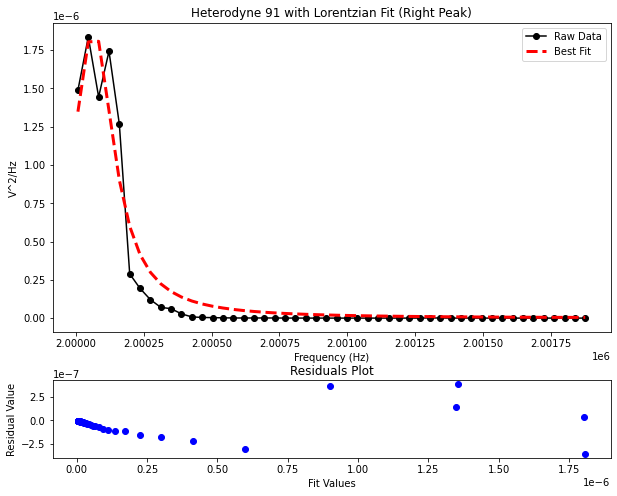

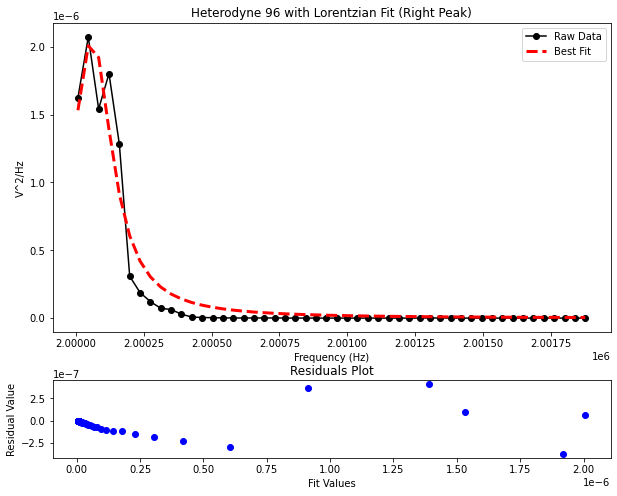

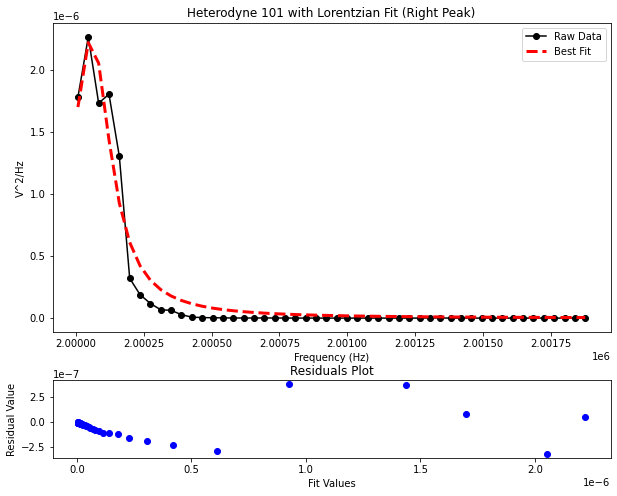

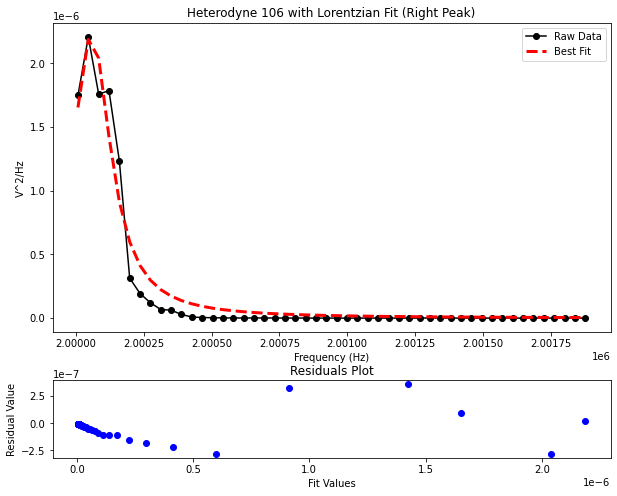

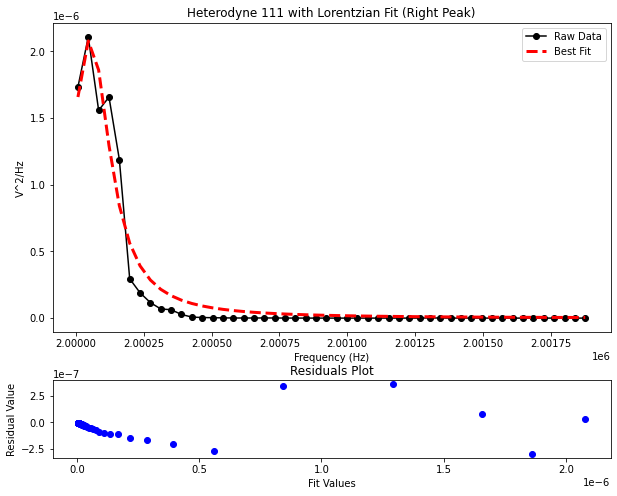

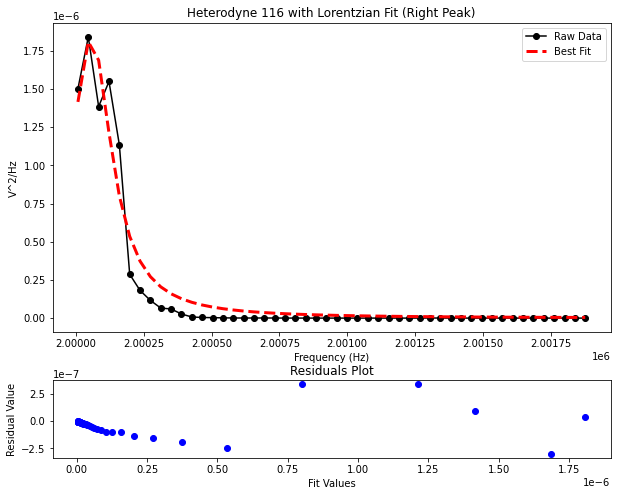

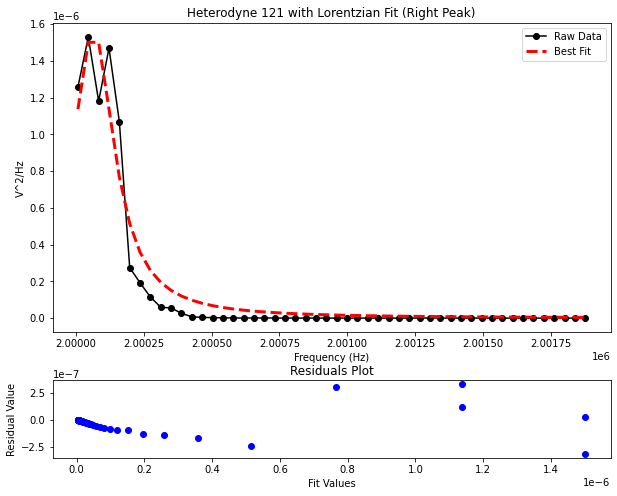

In [12]:
# Plot every 5th heterodyne
units = "V^2/Hz"
for i in range(1, 125, 5):
    title = f"Heterodyne {i} with Lorentzian Fit (Right Peak)"
    heterodyne = HeterodyneData("/content/heterodyne/", f"het_st80_{i}.CSV", "V^2/Hz")
    right_lorentzian = heterodyne.fit_right_peak()
    super_plot(heterodyne.frequencies[:50], heterodyne.spectrum[:50], right_lorentzian.values[:50], title=title, units=units)

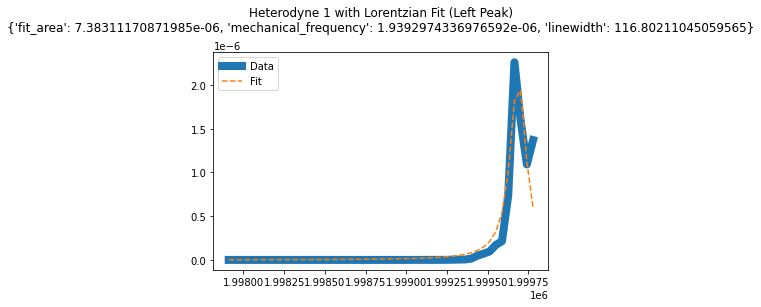

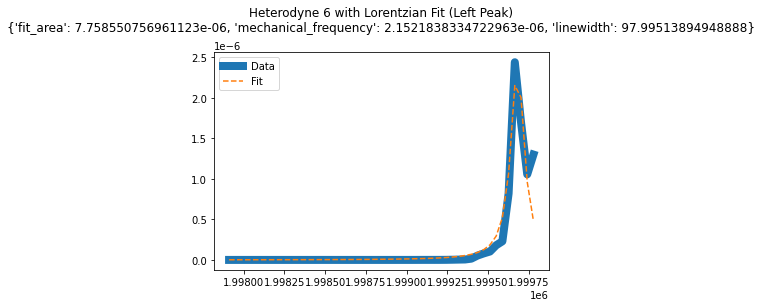

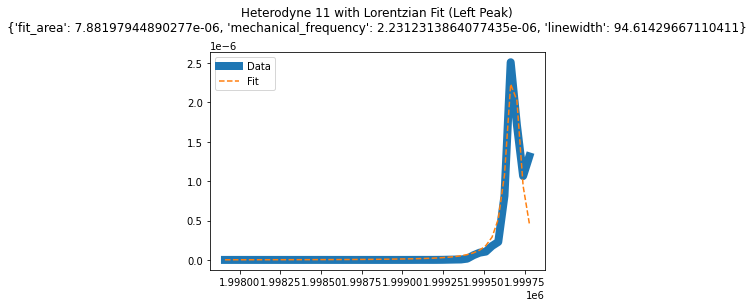

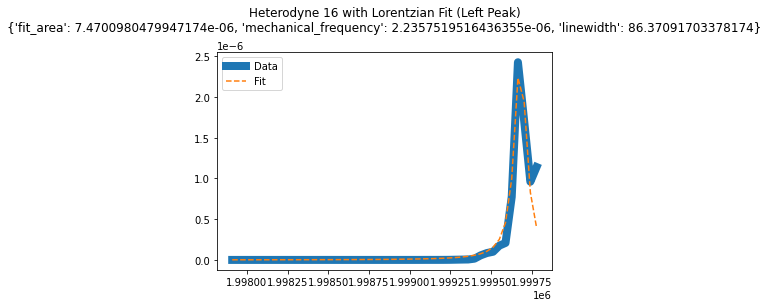

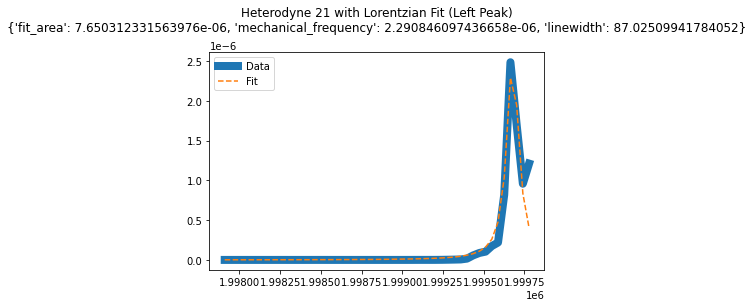

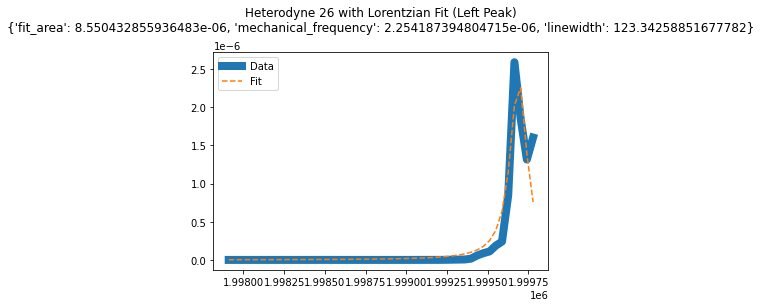

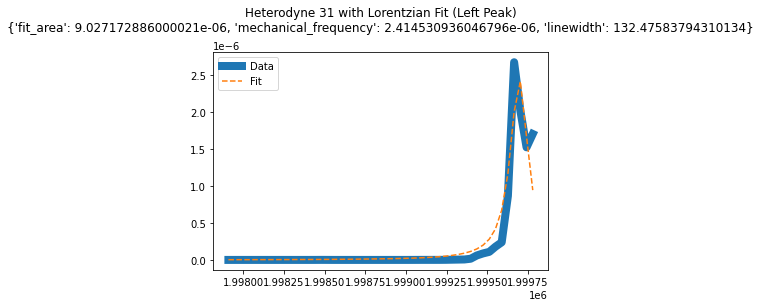

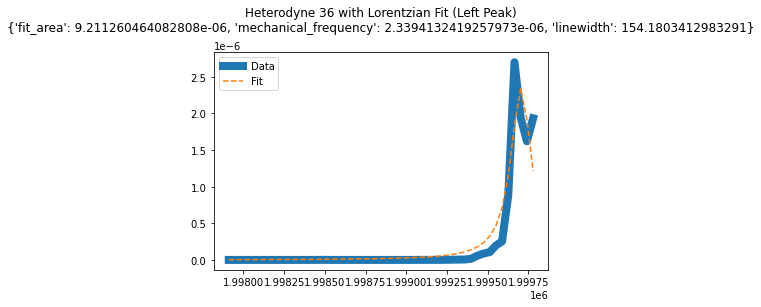

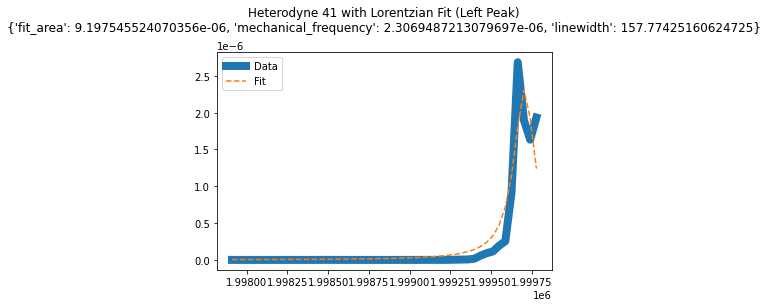

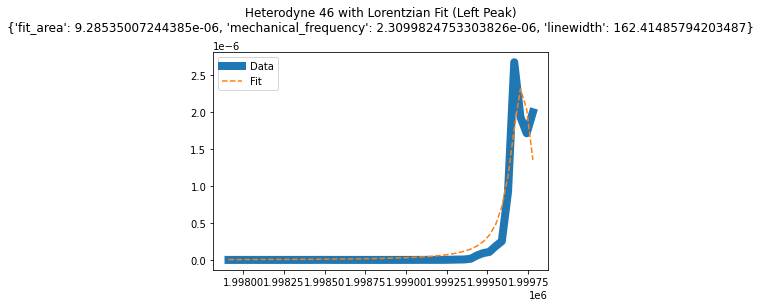

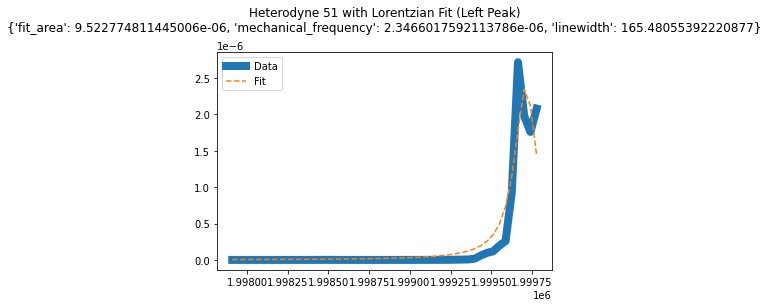

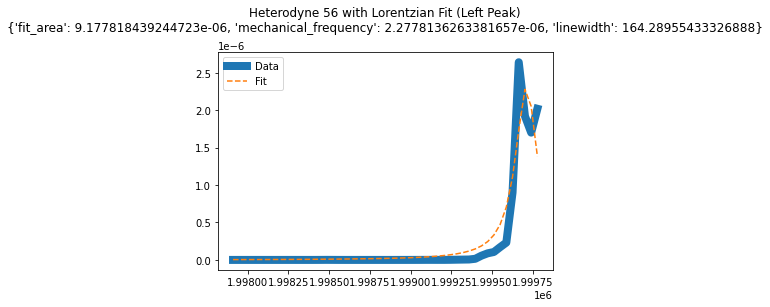

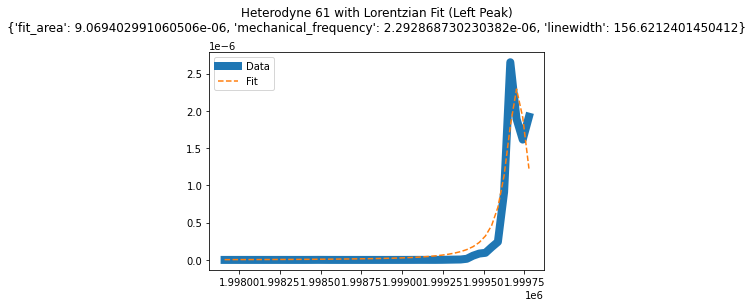

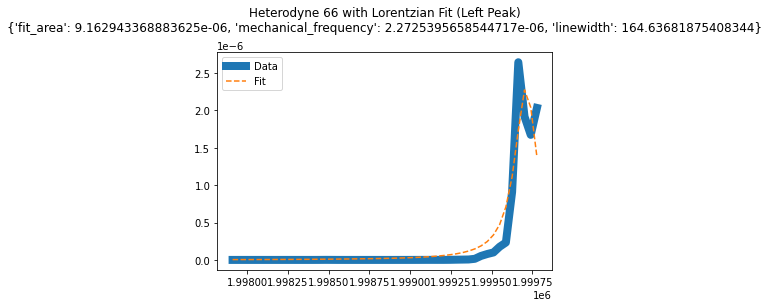

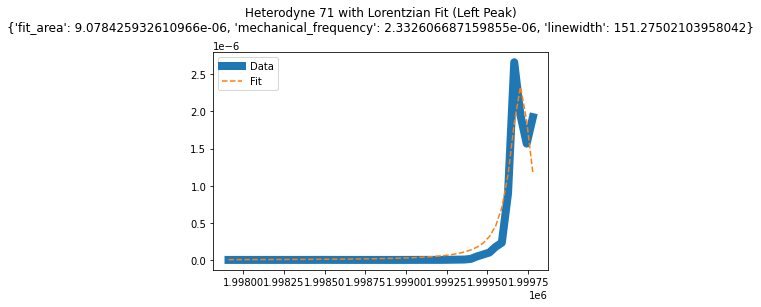

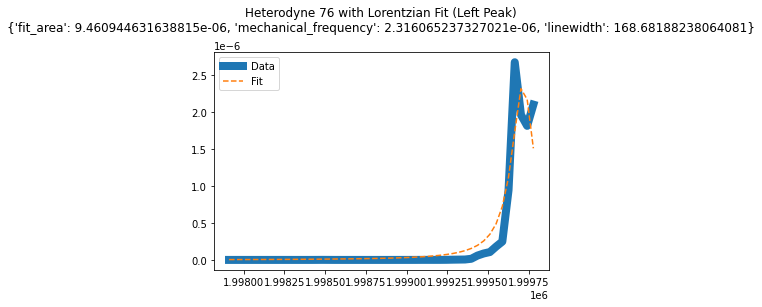

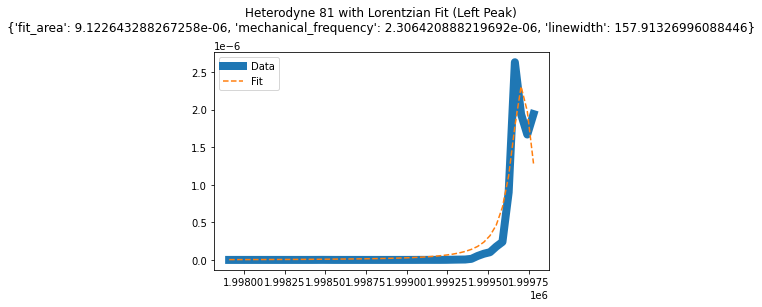

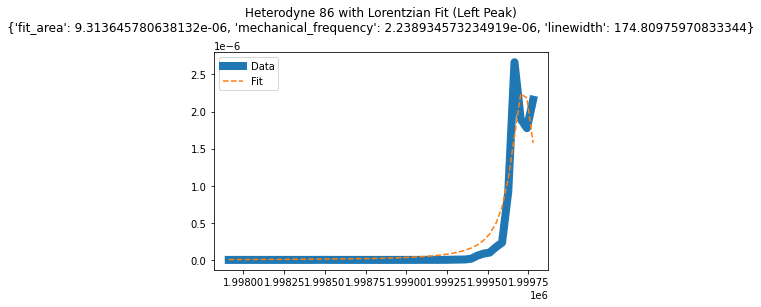

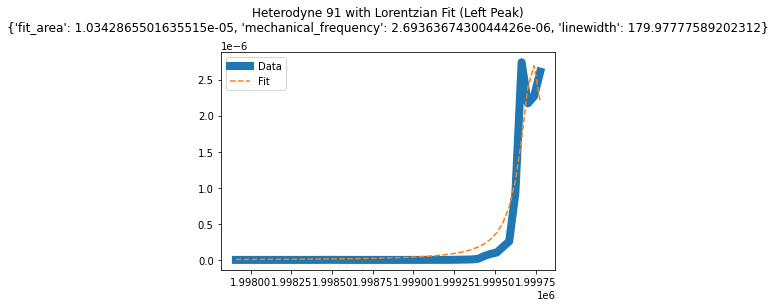

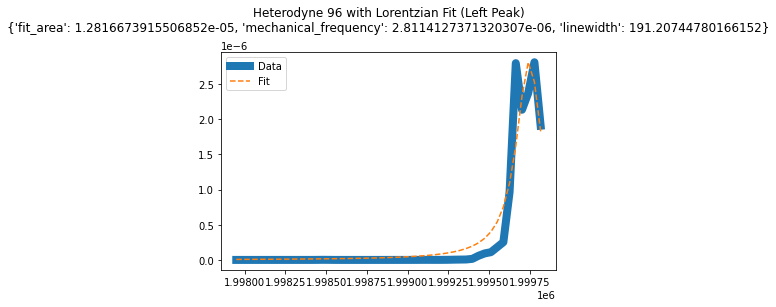

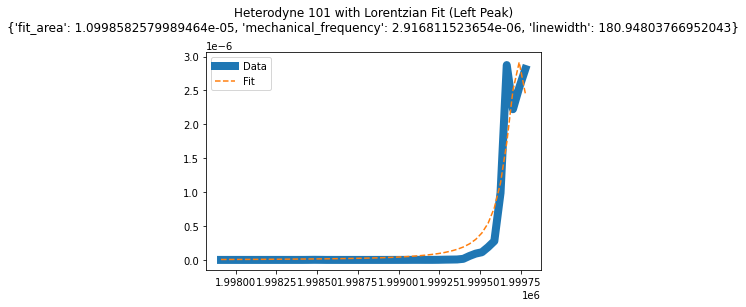

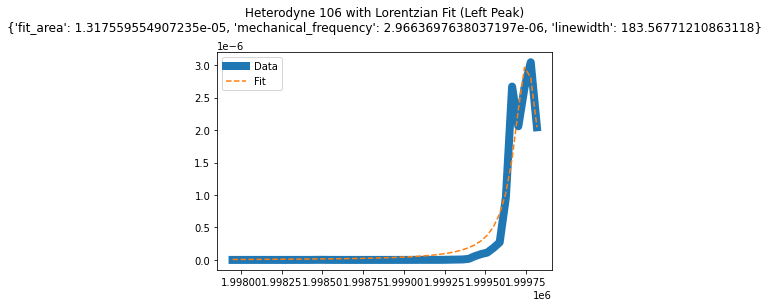

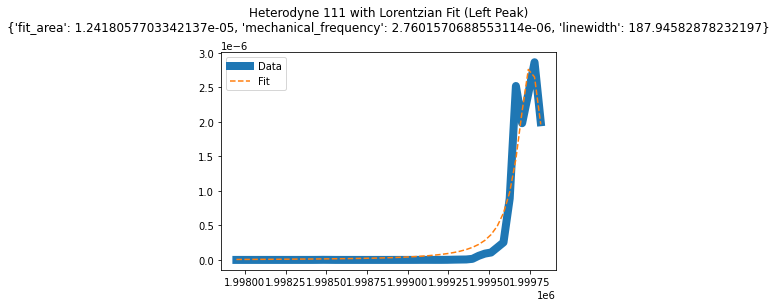

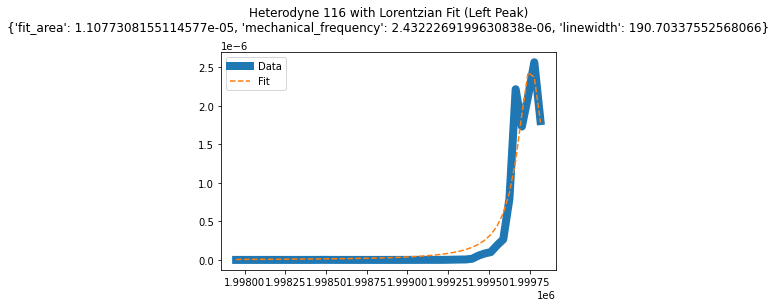

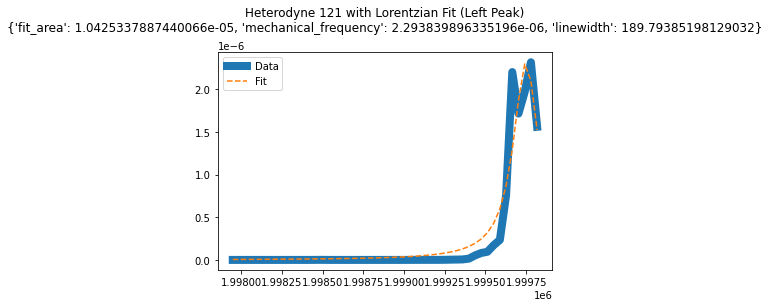

In [ ]:
for i in range(1, 125, 5):
    heterodyne = HeterodyneData("/content/heterodyne/", f"het_st80_{i}.CSV", "V^2/Hz")
    left_lorentzian = heterodyne.fit_left_peak(tune=0.4)
    lorentzian_values = left_lorentzian.all_values()
    plt.plot(heterodyne.frequencies[-50:], heterodyne.spectrum[-50:], label="Data", linewidth=8)
    plt.plot(heterodyne.frequencies[-50:], left_lorentzian.values[-50:], label="Fit", linestyle="dashed")
    plt.title(f"Heterodyne {i} with Lorentzian Fit (Left Peak)\n{lorentzian_values}\n")
    plt.legend()
    plt.show()